In [ ]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import warnings

# Uyarıları gizle
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Keras ve TensorFlow modülleri
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNet

# Diğer kullanışlı kütüphaneler
import matplotlib.pyplot as plt
s

In [2]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [3]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [4]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [5]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [6]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [ ]:
# #### Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS, 3)

# ### Eğitim ve Doğrulama Örnek Sayıları
train_samples_num = get_files(train_path)
val_samples_num = get_files(valid_path)
print(train_samples_num)
print(val_samples_num)


# Birkaç yararlı değeri bildirme
epochs = 10
num_train_samples = train_samples_num
num_val_samples = val_samples_num
train_batch_size = 64
val_batch_size = 64
image_size = 224



39200
1002


In [8]:
# Üreticileri ayarlama
data_gen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size, image_size),
                                             batch_size=train_batch_size)

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size, image_size),
                                             batch_size=val_batch_size)

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False)

Found 39200 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [9]:
# Bir MobileNet modeli oluşturma
mobile = keras.applications.mobilenet.MobileNet()

# Modeli düzenleme
# Modelin son 5 katmanını hariç tutma
x = mobile.layers[-6].output
# Tahminler için dropout ve dense layer ekleme

# Reshape or Flatten the output to 2D
x = keras.layers.Flatten()(x) # Add this line to flatten the output

x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Yeni çıktılı bir model oluşturma
model = Model(inputs=mobile.input, outputs=predictions)

# Modeldeki yeni katmanların özetine bakma
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,580,103 (13.66 MB)

 Trainable params: 3,558,215 (13.57 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [10]:
# Eğitilmeyen katmanların ağırlıklarını dondurma (sadece son 23'ünü eğitme)
for layer in model.layers[:-23]:
    layer.trainable = False

In [11]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

# Modeli melanoma daha duyarlı hale getirmek için ağırlık ekleme
# class_weights={
#     0: 1.0,  # akiec
#     1: 1.0,  # bcc
#     2: 1.0,  # bkl
#     3: 1.0,  # df
#     4: 3.0,  # mel
#     5: 1.0,  # nv
#     6: 1.0,  # vasc
# }

# Save edilmiş model için dosya yolunu bildirme
filepath = "C:/Users/esraa/Desktop/base_dir/mobilNet_model.keras"

# Modelin en iyi versiyonunu save etmek için bir checkpoint bildirme
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Öğrenme durgunlaştıkça öğrenme oranını azaltma
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [ ]:
# Modeli uydurma
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    # class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/10
122/612 ━━━━━━━━━━━━━━━━━━━━ 14:16 2s/step - categorical_accuracy: 0.5057 - loss: 5.2990

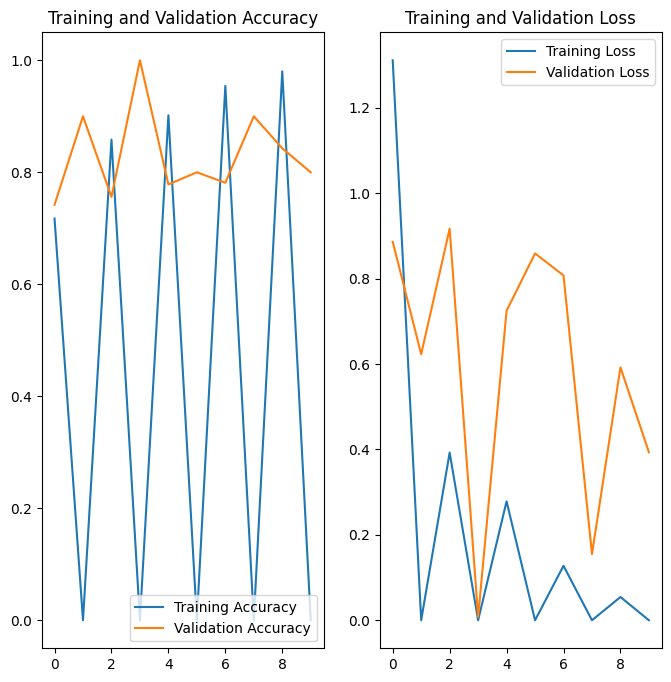

In [ ]:
#Eğitim sonuçlarını görselleştirme.
#Ağı eğittikten sonra elde edilen sonuçları görselleştirme.

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step
Precision: 0.8361265807669512
Recall: 0.8423153692614771
F1 Score: 0.8339412166980829


In [ ]:
# Model ağırlıklarını yükleme
model.load_weights(filepath)

# Modeli değerlendirme
val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)
print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - categorical_accuracy: 0.5514 - loss: 1.6923
val_loss: 0.9018906950950623
val_cat_acc: 0.757056474685669


In [ ]:
# Modeli hesaplama
# Son dönümün hesabı
val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


# En iyi dönüm için hesaplama
model.load_weights(filepath)

val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, verbose=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - categorical_accuracy: 0.5514 - loss: 1.6923
val_loss: 0.9018906950950623
val_cat_acc: 0.757056474685669
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - categorical_accuracy: 0.5514 - loss: 1.6923
val_loss: 0.9018906950950623
val_cat_acc: 0.757056474685669
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step


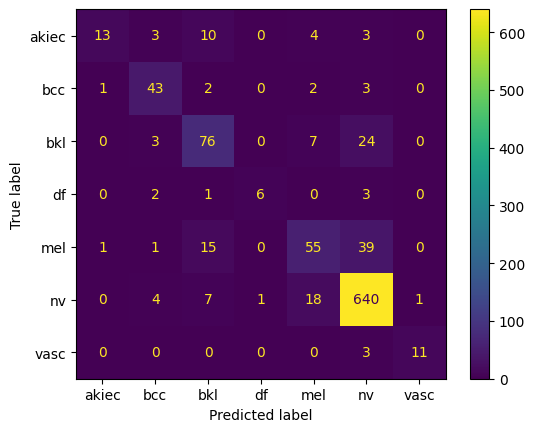

In [ ]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrisi oluşturma
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Confusion matrisini görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()

Normalize edilmiş Confusion matris
[[0.84848485 0.         0.03030303 0.         0.         0.12121212
  0.        ]
 [0.37254902 0.09803922 0.01960784 0.01960784 0.01960784 0.41176471
  0.05882353]
 [0.12727273 0.         0.29090909 0.         0.         0.58181818
  0.        ]
 [0.16666667 0.         0.         0.58333333 0.         0.25
  0.        ]
 [0.10810811 0.         0.04504505 0.00900901 0.13513514 0.69369369
  0.00900901]
 [0.00596125 0.         0.00447094 0.         0.00298063 0.98360656
  0.00298063]
 [0.         0.         0.         0.         0.         0.07142857
  0.92857143]]


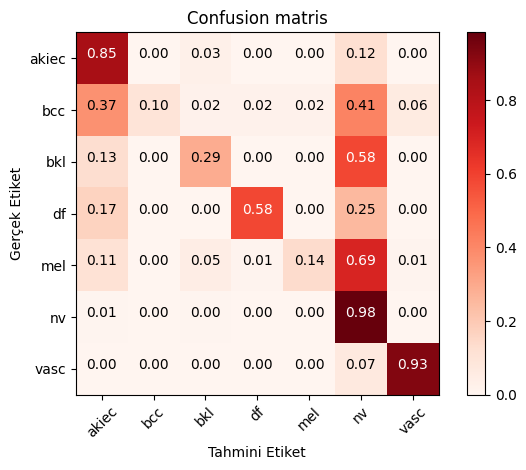

In [ ]:
# Confusion matrisi oluşturan fonksiyon
def plot_confusion_matrix(cm, classes, normalize=True,
                          title='Confusion matris', cmap=plt.cm.Reds):

    #Bu fonksiyon, karışıklık matrisini yazdırır ve çizer. Normalleştirme, 'normalize=True' ayarlanarak uygulanabilir.

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalize edilmiş Confusion matris")
    else:
        print('Normalize edilmemiş Confusion matris')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmini Etiket')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

image shape: (224, 224, 3)


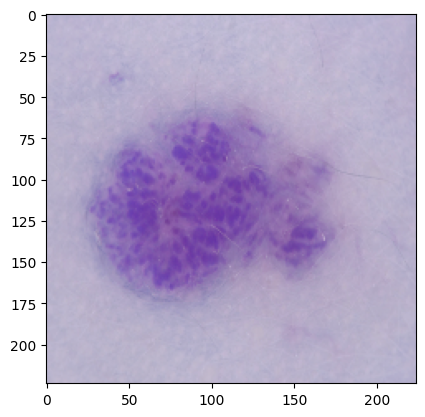

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[1.2074234e-12 2.7178665e-10 2.7923482e-12 1.0787886e-12 2.4070538e-08
  4.5714073e-06 9.9999535e-01]]
vasc


In [ ]:

# read sample test image
import cv2
img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])


In [ ]:
import tensorflow as tf

# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/mobilNet_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/mobilNet_model.h5")
